In [199]:
import bisect
import datetime
from dateutil.parser import parse
import itertools
from itertools import product
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
import matplotlib.pyplot as plt
from multiprocessing.dummy import Pool as ThreadPool
import nolds
import numpy as np
import os
import pandas as pd
import pathlib
from PreprocessFcns import *
import pywt
import random
import scipy
from scipy.fftpack import fft
from scipy.signal import butter, welch, filtfilt, resample, find_peaks
from scipy.stats import skew, kurtosis, entropy, pearsonr
import seaborn as sns
import sklearn
from sklearn import multiclass
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneGroupOut
import time
%matplotlib inline

Using TensorFlow backend.


In [3]:
path = r'//FS2.smpp.local\\RTO\\CIS-PD Study\MJFF Curation\Finalized Dataset'

In [220]:
# generate task abbreviation dictionary
ClinicTasks = {
    'Stndg'    : 'Standing',
    'Wlkg'     : 'Walking',
    'WlkgCnt'  : 'Walking while counting',
    'FtnR'     : 'Finger to nose--right hand',
    'FtnL'     : 'Finger to nose--left hand',
    'RamR'     : 'Alternating right hand movements',
    'RamL'     : 'Alternating left hand movements',
    'SitStand' : 'Sit to stand',
    'Drwg'     : 'Drawing on a paper',
    'Typg'     : 'Typing on a computer keyboard',
    'NtsBts'   : 'Assembling nuts and bolts',
    'Drnkg'    : 'Taking a glass of water and drinking',
    'Sheets'   : 'Organizing sheets in a folder',
    'Fldg'     : 'Folding towels',
    'Sitng'    : 'Sitting'
}

In [13]:
# generate visit number dictionary
VisitNumber = {
    '2 Weeks: Time 0'   : 0,
    '2 Weeks: Time 30'  : 1,
    '2 Weeks: Time 60'  : 2,
    '2 Weeks: Time 90'  : 3,
    '2 Weeks: Time 120' : 4,
    '2 Weeks: Time 150' : 5,
    '1 Month'           : 6
}

In [266]:
def filterMetaData(tasks):

    metaDataFull = pd.read_csv(os.path.join(path, 'Metadata Tables', 'Table4.csv'))
    indices = (x for x in range(len(metaDataFull)) if metaDataFull.TaskAbb.values[x] in tasks)
    metaDataFull = metaDataFull.loc[indices]

    SubjID = []
    Visit = []
    TaskAbb = []
    AccFile = []
    Tremor = []
    for record in metaDataFull.iterrows():
        if (type(record[1]['Side']) == float):
            continue
        if (np.isnan(record[1]['Tremor - ' + record[1]['Side']])):
            continue
        filename = (str(int(record[1]['SubjID'])) + '_' +
                            str(VisitNumber[record[1]['Visit']]) + '_' + 
                            record[1]['TaskAbb'] + '.csv')
        filepath = os.path.join(path, 'TaskAcc', filename)
        if not os.path.exists(filepath):
            continue
        SubjID = SubjID + [int(record[1]['SubjID'])]
        Visit = Visit + [VisitNumber[record[1]['Visit']]]
        TaskAbb = TaskAbb + [record[1]['TaskAbb']]
        AccFile = AccFile + [filename]
        Tremor = Tremor + [int(record[1]['Tremor - ' + record[1]['Side']])]
    TremorBIN = [int(t > 0) for t in Tremor]
    metaData = pd.DataFrame({'SubjID': SubjID, 
                             'Visit': Visit, 
                             'TaskAbb': TaskAbb,
                             'AccFile': AccFile,
                             'Tremor': Tremor,
                             'TremorBIN': TremorBIN})
    print('Records = ' + str(len(metaData)))
    
    return metaData
    
def formatInputNN(tasks, metaData):
    
    NormRMSE = 0.01
    Data = []
    Labels = []
    Subjects = []
    for record in metaData.iterrows():
        recording = pd.read_csv(os.path.join(path, 'TaskAcc', record[1]['AccFile']), 
                                parse_dates = ['timestamp'])[['timestamp', 'x', 'y', 'z']]
        recording.columns = ['Timestamp', 'X', 'Y', 'Z']
        recording['Mag'] = np.sqrt((recording.X**2 + recording.Y**2 + recording.Z**2))
        recording = recording.sort_values(by = 'Timestamp', axis = 0)
        recording['TimeWdw'] = [(tm - datetime.timedelta(minutes = 0,
                                                         seconds = tm.second % 2.5,
                                                         microseconds = tm.microsecond)) 
                                for tm in recording.Timestamp]
        recording['TimeIdx'] = (recording.Timestamp.values - 
                                recording.Timestamp.values[0]).astype('timedelta64[ms]').astype(int)
        recording = recording.set_index('TimeIdx')
        for t in recording.TimeWdw.unique():
            clip = recording.loc[(recording.TimeWdw == t) | 
                                 (recording.TimeWdw == (t + np.timedelta64(2500, 'ms')))]
            if len(clip) < 200:
                continue
#             if ((tasks == ['Sitng', 'Stndg']) or 
#                 (tasks == ['Stndg', 'Sitng']) or 
#                 (tasks == ['Sitng']) or 
#                 (tasks == ['Stndg'])) and ((np.sqrt(np.mean((clip.Mag - np.mean(clip.Mag))**2))) < NormRMSE):
#                 continue
            fx = scipy.interpolate.interp1d(range(len(clip)), clip.X.values)
            fy = scipy.interpolate.interp1d(range(len(clip)), clip.Y.values)
            fz = scipy.interpolate.interp1d(range(len(clip)), clip.Z.values)
            clipX = fx(np.linspace(start = 0, stop = len(clip) - 1, num = 500))
            clipY = fy(np.linspace(start = 0, stop = len(clip) - 1, num = 500))
            clipZ = fz(np.linspace(start = 0, stop = len(clip) - 1, num = 500))
            datasteps = []
            for dpx, dpy, dpz in zip(clipX, clipY, clipZ):
                datasteps = datasteps + [[dpx, dpy, dpz]]
            Data = Data + [datasteps]
            Labels = Labels + [record[1]['TremorBIN']]
            Subjects = Subjects + [record[1]['SubjID']]
    Data = np.array(Data)
    Labels = np.array(Labels)
    Subjects = np.array(Subjects)
    print('(Samples, Timesteps, Features (Axes)) = ' + str(Data.shape))
    print('Labels = ' + str(len(Labels)))
    print('Subjects = ' + str(len(set(Subjects))))
    
    return Data, Labels, Subjects

In [267]:
metaData = filterMetaData(['Wlkg', 'WlkgCnt'])
Data, Labels, Subjects = formatInputNN(['Wlkg', 'WlkgCnt'], metaData)

Records = 265
(Samples, Timesteps, Features (Axes)) = (3553, 500, 3)
Labels = 3553
Subjects = 23


Validation Subject: 1003
Train on 21366 samples, validate on 919 samples
Epoch 1/10
21366/21366 [==============================] - 45s 2ms/step - loss: 0.4591 - val_loss: 0.3623
Epoch 2/10
21366/21366 [==============================] - 26s 1ms/step - loss: 0.3094 - val_loss: 0.3173
Epoch 3/10
21366/21366 [==============================] - 27s 1ms/step - loss: 0.2815 - val_loss: 0.3161
Epoch 4/10
21366/21366 [==============================] - 27s 1ms/step - loss: 0.2789 - val_loss: 0.3158
Epoch 5/10
21366/21366 [==============================] - 27s 1ms/step - loss: 0.2760 - val_loss: 0.3157
Epoch 6/10
21366/21366 [==============================] - 27s 1ms/step - loss: 0.2759 - val_loss: 0.3157
Epoch 7/10
21366/21366 [==============================] - 27s 1ms/step - loss: 0.2757 - val_loss: 0.3157
Epoch 8/10
21366/21366 [==============================] - 27s 1ms/step - loss: 0.2758 - val_loss: 0.3156
Epoch 9/10
21366/21366 [==============================] - 27s 1ms/step - loss: 0.2758 -

21130/21130 [==============================] - 29s 1ms/step - loss: 0.2969 - val_loss: 0.0724
Epoch 4/10
21130/21130 [==============================] - 26s 1ms/step - loss: 0.2970 - val_loss: 0.0717
Epoch 5/10
21130/21130 [==============================] - 27s 1ms/step - loss: 0.2970 - val_loss: 0.0712
Epoch 6/10
21130/21130 [==============================] - 27s 1ms/step - loss: 0.2964 - val_loss: 0.0704
Epoch 7/10
21130/21130 [==============================] - 27s 1ms/step - loss: 0.2964 - val_loss: 0.0699
Epoch 8/10
21130/21130 [==============================] - 27s 1ms/step - loss: 0.2955 - val_loss: 0.0683
Epoch 9/10
21130/21130 [==============================] - 27s 1ms/step - loss: 0.2928 - val_loss: 0.0625
Epoch 10/10
21130/21130 [==============================] - 27s 1ms/step - loss: 0.2904 - val_loss: 0.0625
Validation Subject: 1020
Train on 22107 samples, validate on 178 samples
Epoch 1/10
22107/22107 [==============================] - 45s 2ms/step - loss: 0.4689 - val_loss:

21198/21198 [==============================] - 26s 1ms/step - loss: 0.2600 - val_loss: 0.5400
Epoch 7/10
21198/21198 [==============================] - 26s 1ms/step - loss: 0.2598 - val_loss: 0.5400
Epoch 8/10
21198/21198 [==============================] - 26s 1ms/step - loss: 0.2599 - val_loss: 0.5400
Epoch 9/10
21198/21198 [==============================] - 26s 1ms/step - loss: 0.2598 - val_loss: 0.5400
Epoch 10/10
21198/21198 [==============================] - 26s 1ms/step - loss: 0.2598 - val_loss: 0.5400
Validation Subject: 1039
Train on 21245 samples, validate on 1040 samples
Epoch 1/10
21245/21245 [==============================] - 45s 2ms/step - loss: 0.4749 - val_loss: 0.2631
Epoch 2/10
21245/21245 [==============================] - 27s 1ms/step - loss: 0.3307 - val_loss: 0.0116
Epoch 3/10
21245/21245 [==============================] - 27s 1ms/step - loss: 0.2949 - val_loss: 0.0066
Epoch 4/10
21245/21245 [==============================] - 27s 1ms/step - loss: 0.2958 - val_loss

C:\Users\rpieper\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


Validation Subject: 1046
Train on 21227 samples, validate on 1058 samples
Epoch 1/10
21227/21227 [==============================] - 46s 2ms/step - loss: 0.4476 - val_loss: 0.3848
Epoch 2/10
21227/21227 [==============================] - 26s 1ms/step - loss: 0.2920 - val_loss: 0.4186
Epoch 3/10
21227/21227 [==============================] - 26s 1ms/step - loss: 0.2719 - val_loss: 0.4180
Epoch 4/10
21227/21227 [==============================] - 27s 1ms/step - loss: 0.2710 - val_loss: 0.4179
Epoch 5/10
21227/21227 [==============================] - 26s 1ms/step - loss: 0.2709 - val_loss: 0.4178
Epoch 6/10
21227/21227 [==============================] - 26s 1ms/step - loss: 0.2708 - val_loss: 0.4178
Epoch 7/10
21227/21227 [==============================] - 26s 1ms/step - loss: 0.2708 - val_loss: 0.4178
Epoch 8/10
21227/21227 [==============================] - 26s 1ms/step - loss: 0.2706 - val_loss: 0.4178
Epoch 9/10
21227/21227 [==============================] - 26s 1ms/step - loss: 0.2694 

C:\Users\rpieper\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Validation Subject: 1050
Train on 21327 samples, validate on 958 samples
Epoch 1/10
21327/21327 [==============================] - 47s 2ms/step - loss: 0.4422 - val_loss: 0.5505
Epoch 2/10
21327/21327 [==============================] - 27s 1ms/step - loss: 0.2858 - val_loss: 0.5932
Epoch 3/10
21327/21327 [==============================] - 26s 1ms/step - loss: 0.2696 - val_loss: 0.5986
Epoch 4/10
21327/21327 [==============================] - 27s 1ms/step - loss: 0.2683 - val_loss: 0.6016
Epoch 5/10
21327/21327 [==============================] - 27s 1ms/step - loss: 0.2660 - val_loss: 0.6039
Epoch 6/10
21327/21327 [==============================] - 26s 1ms/step - loss: 0.2628 - val_loss: 0.5860
Epoch 7/10
21327/21327 [==============================] - 26s 1ms/step - loss: 0.2627 - val_loss: 0.5811
Epoch 8/10
21327/21327 [==============================] - 26s 1ms/step - loss: 0.2627 - val_loss: 0.5782
Epoch 9/10
21327/21327 [==============================] - 26s 1ms/step - loss: 0.2627 -

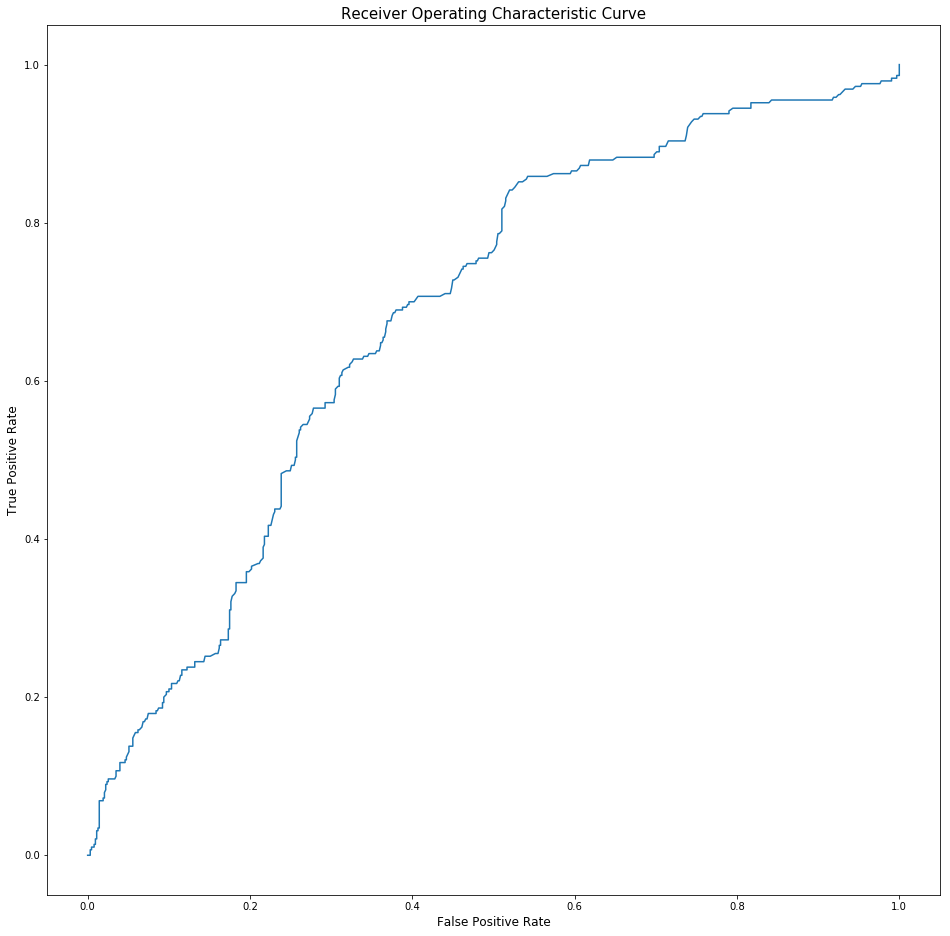

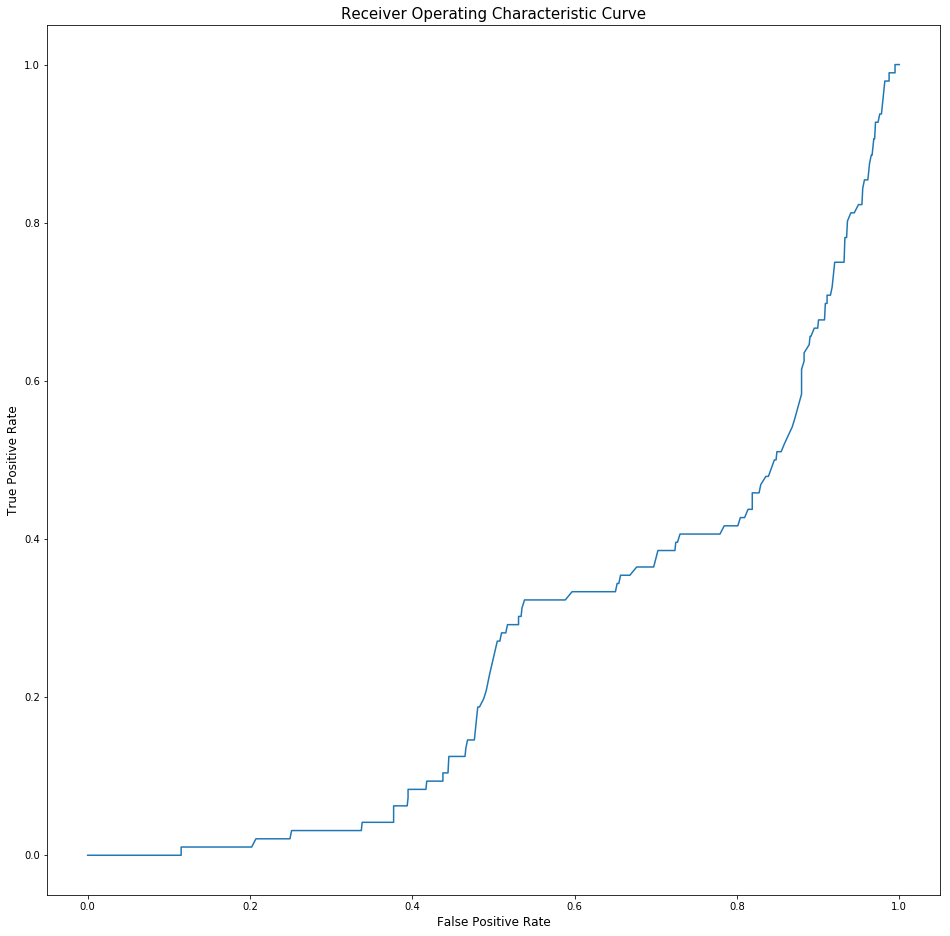

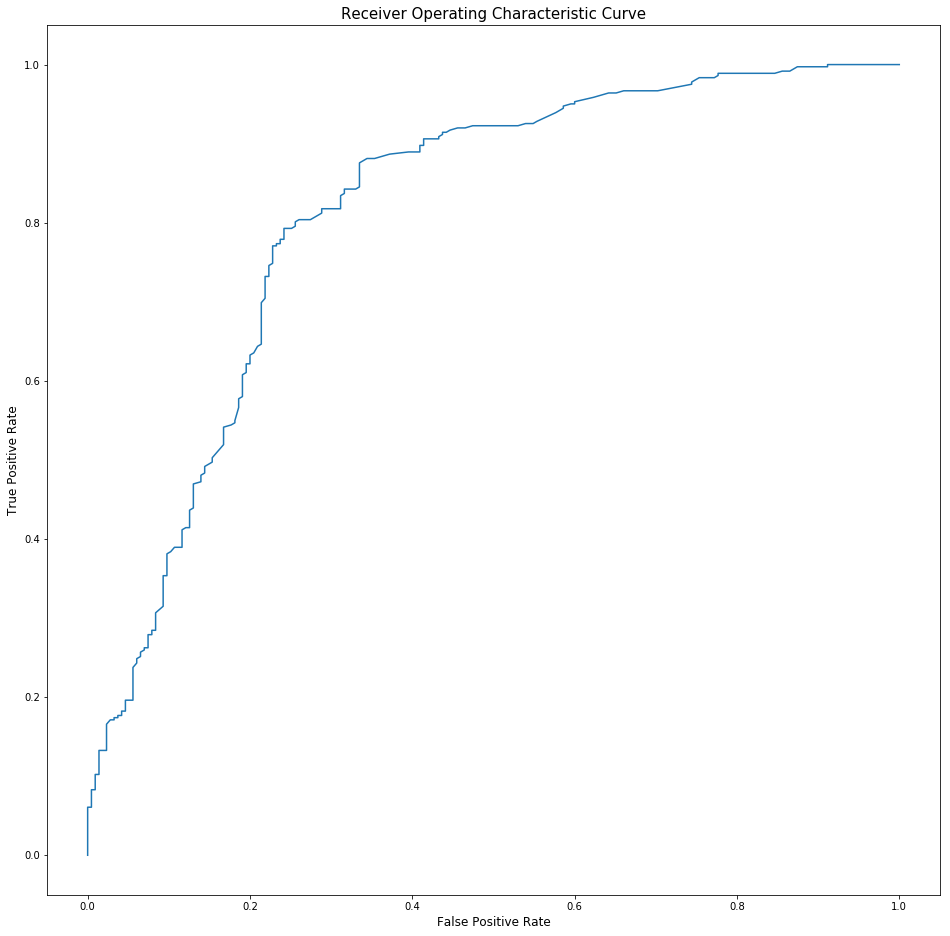

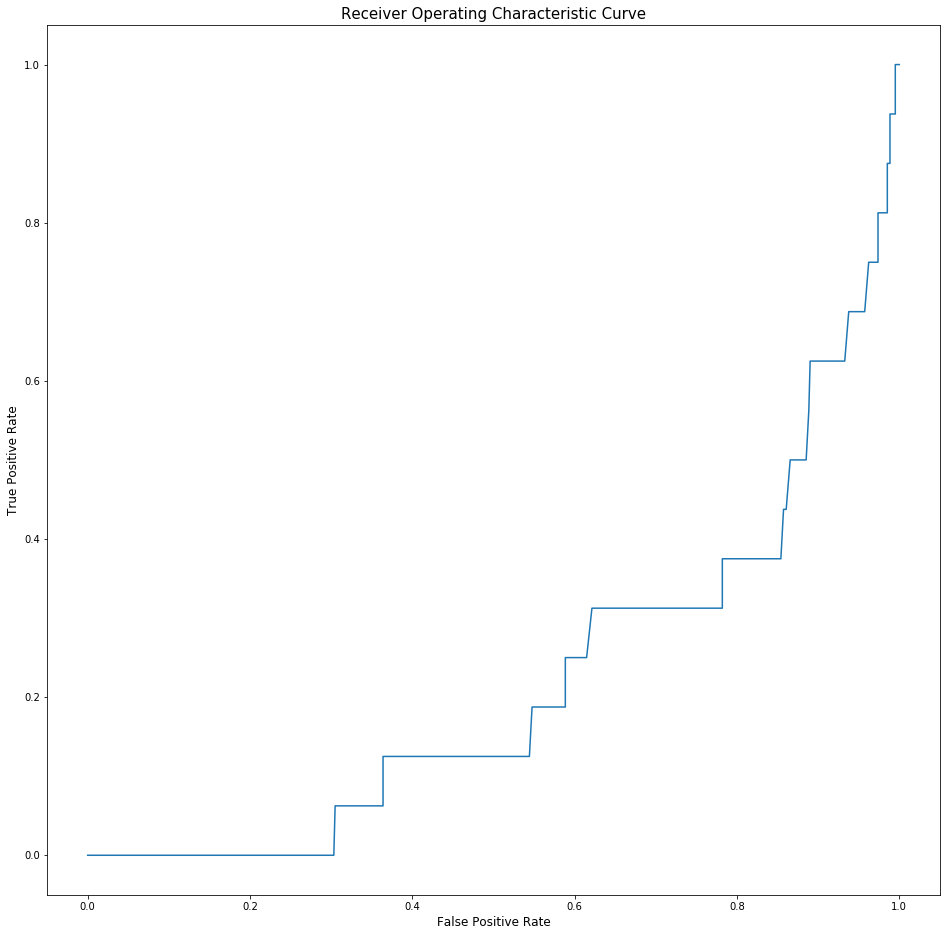

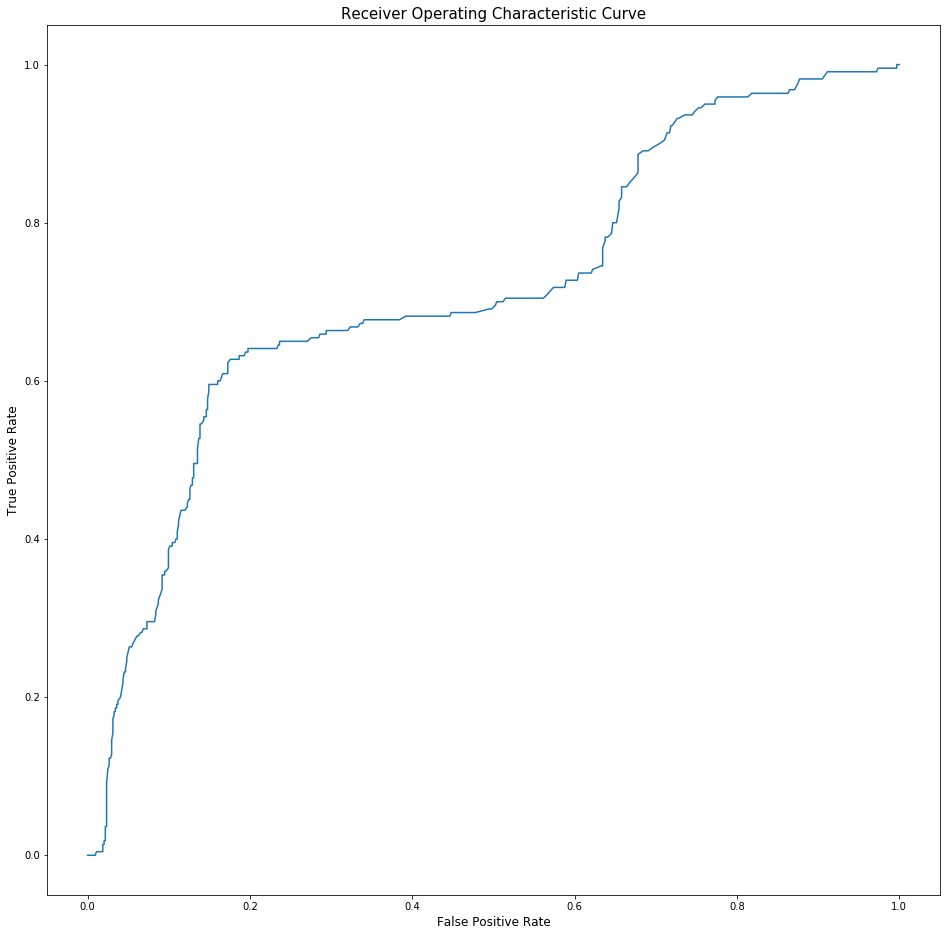

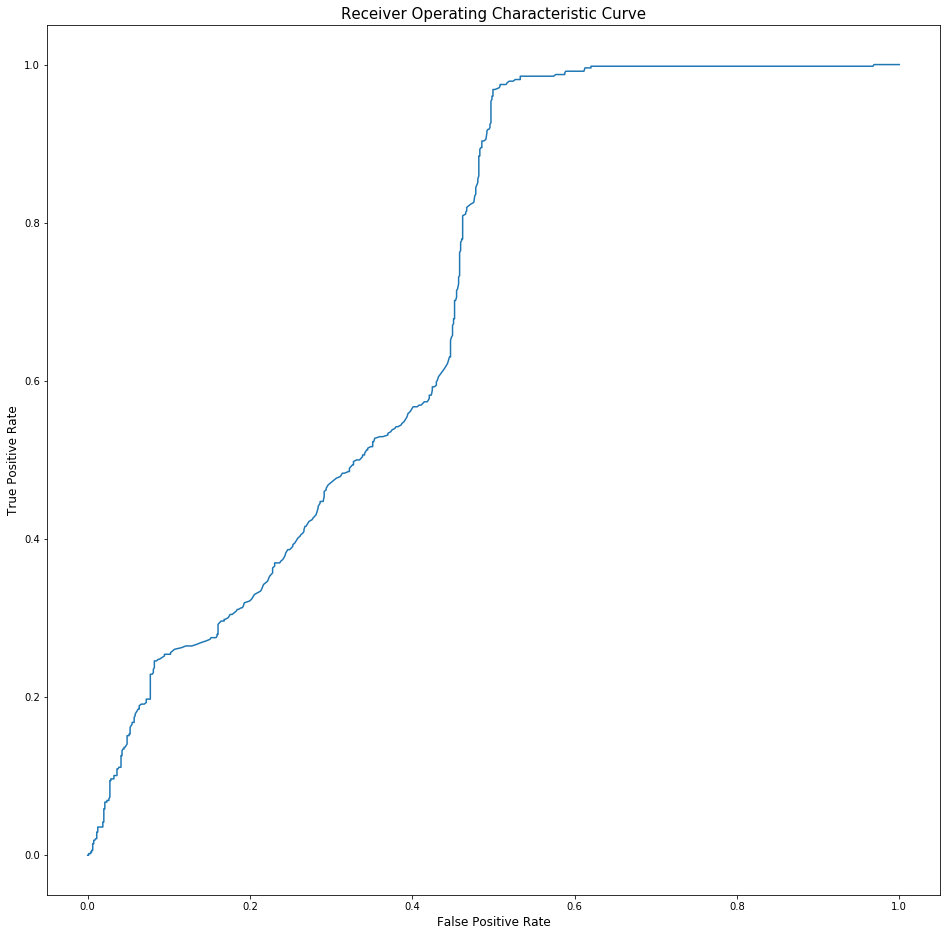

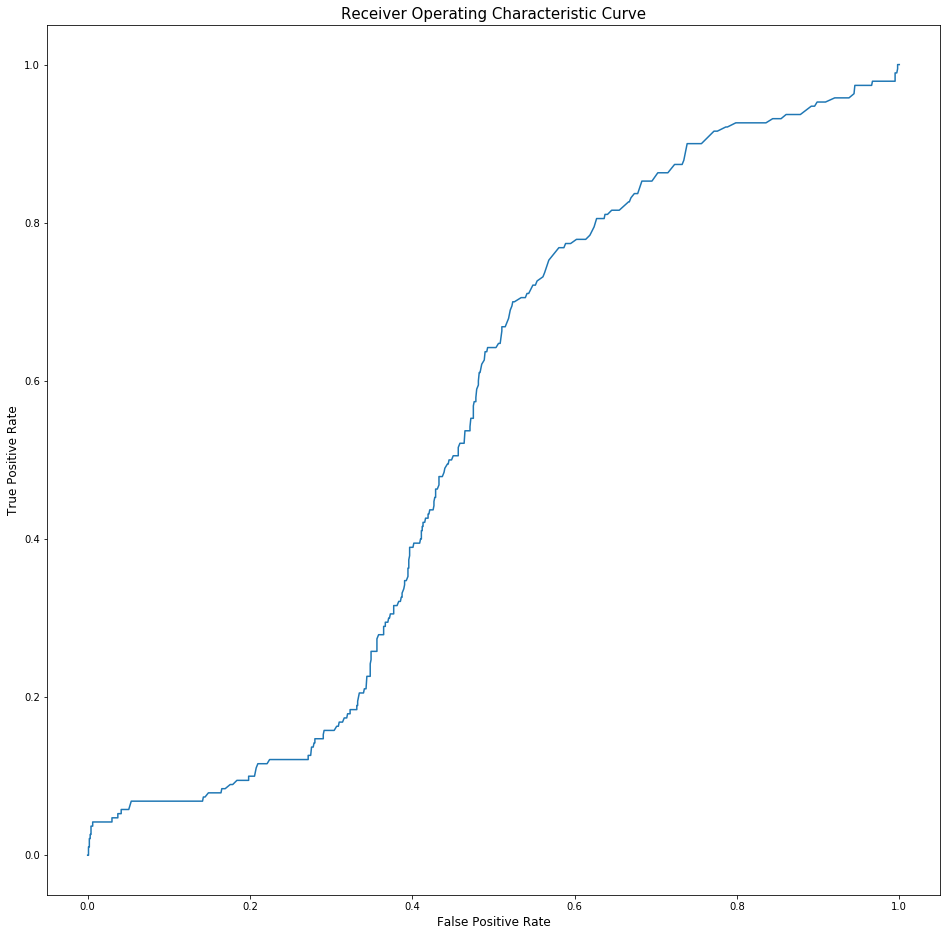

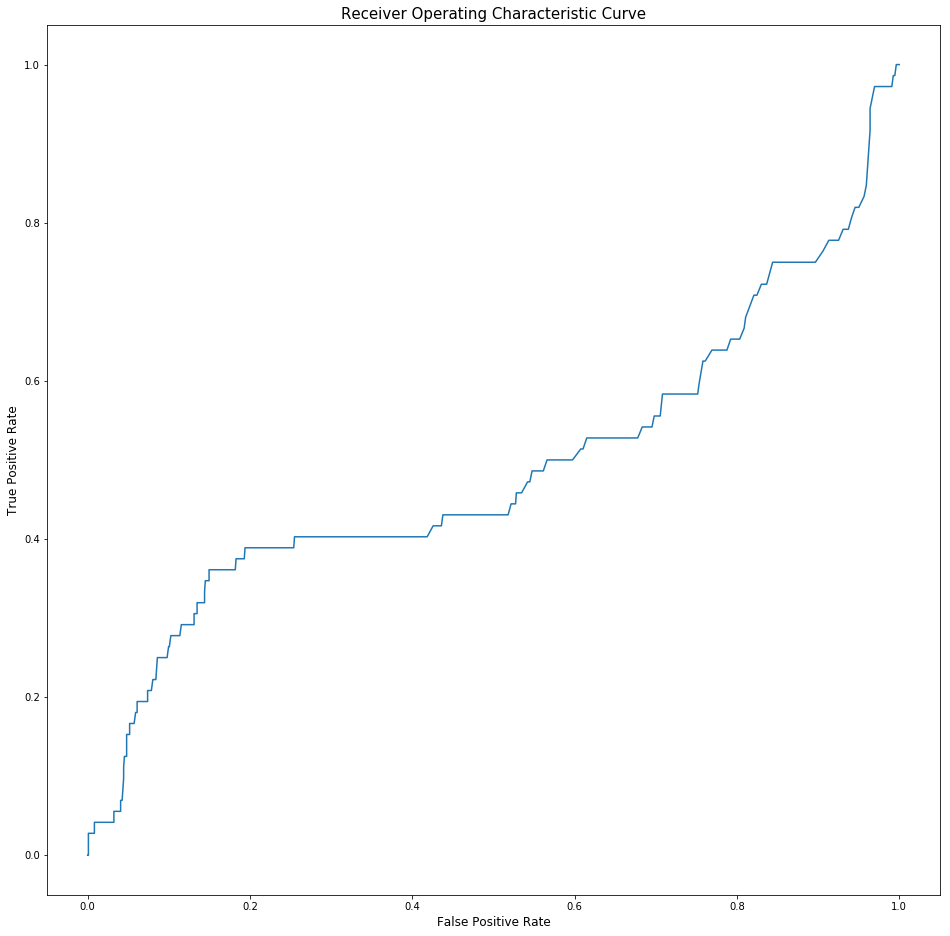

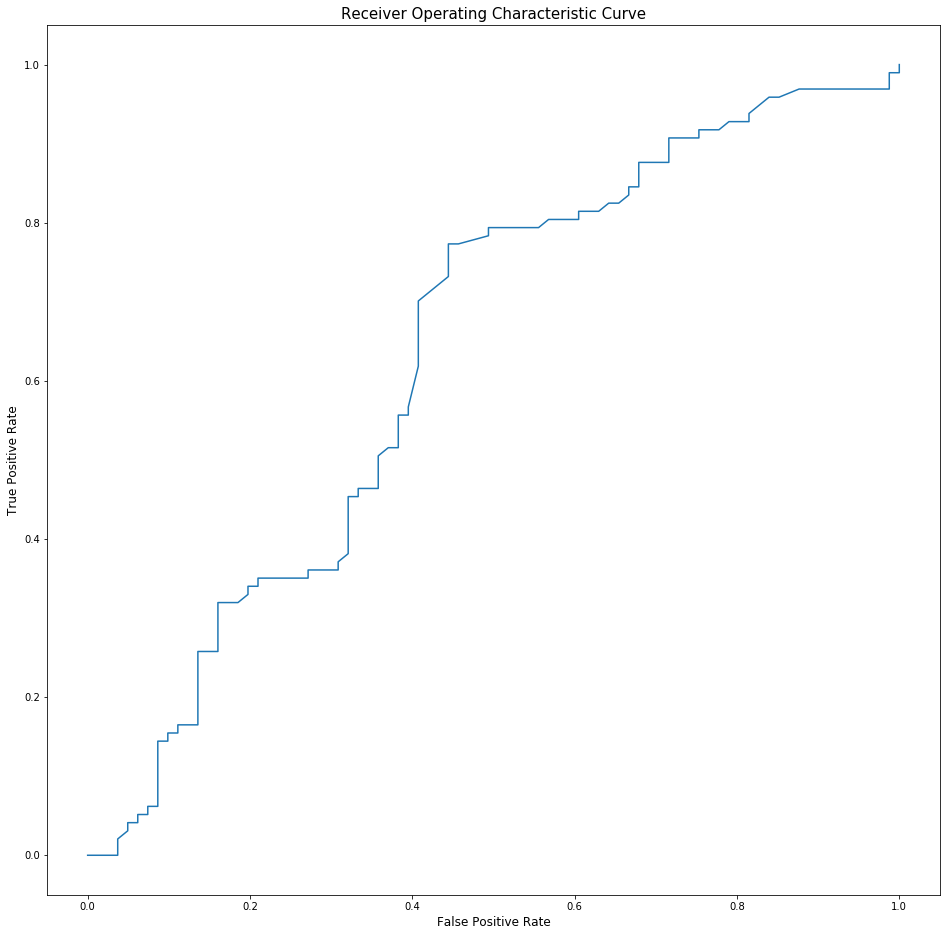

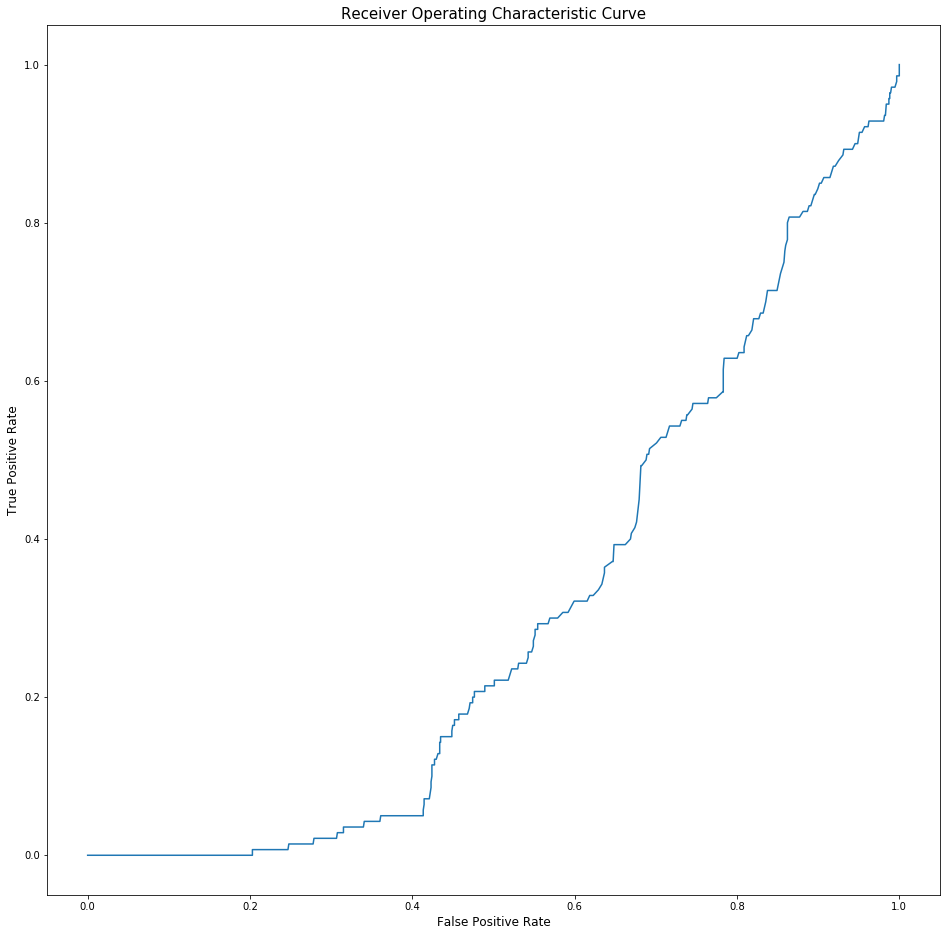

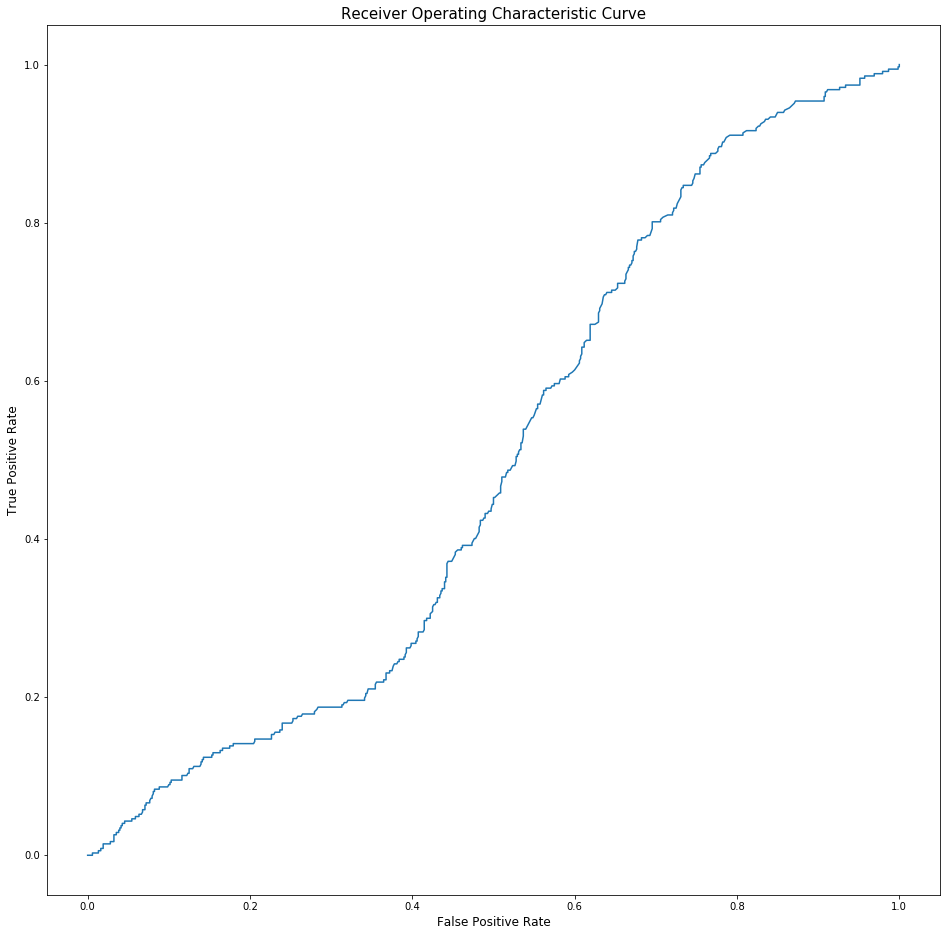

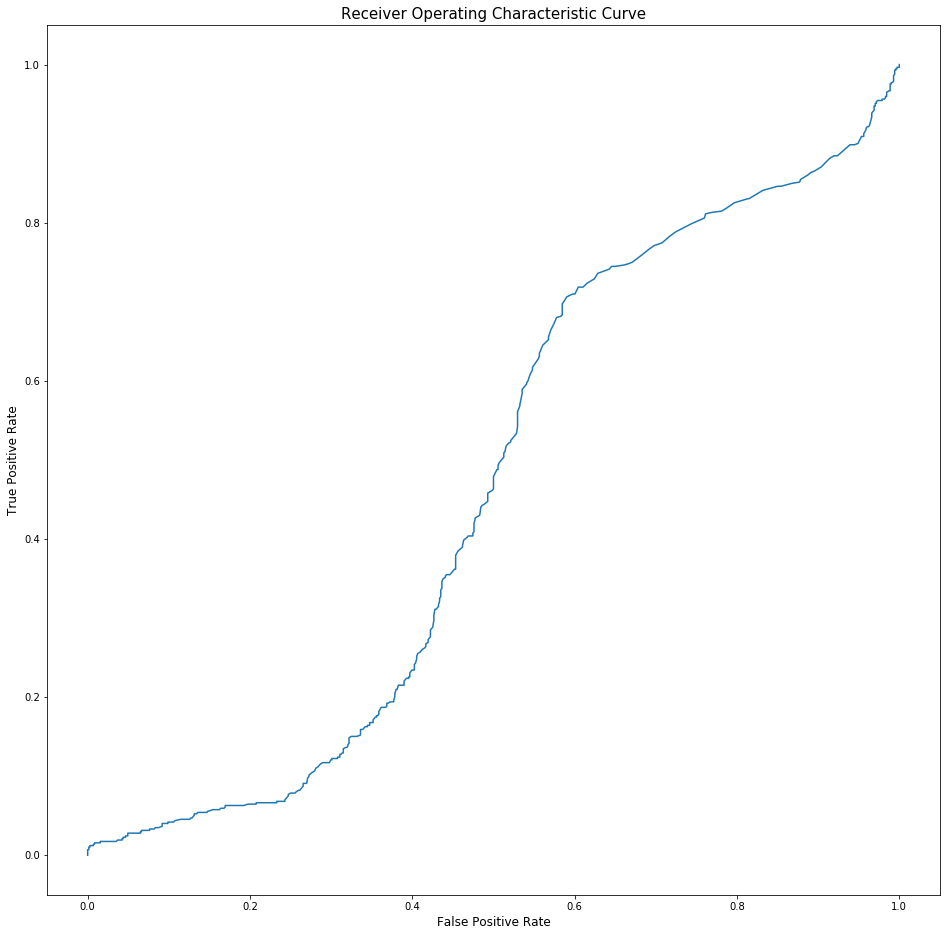

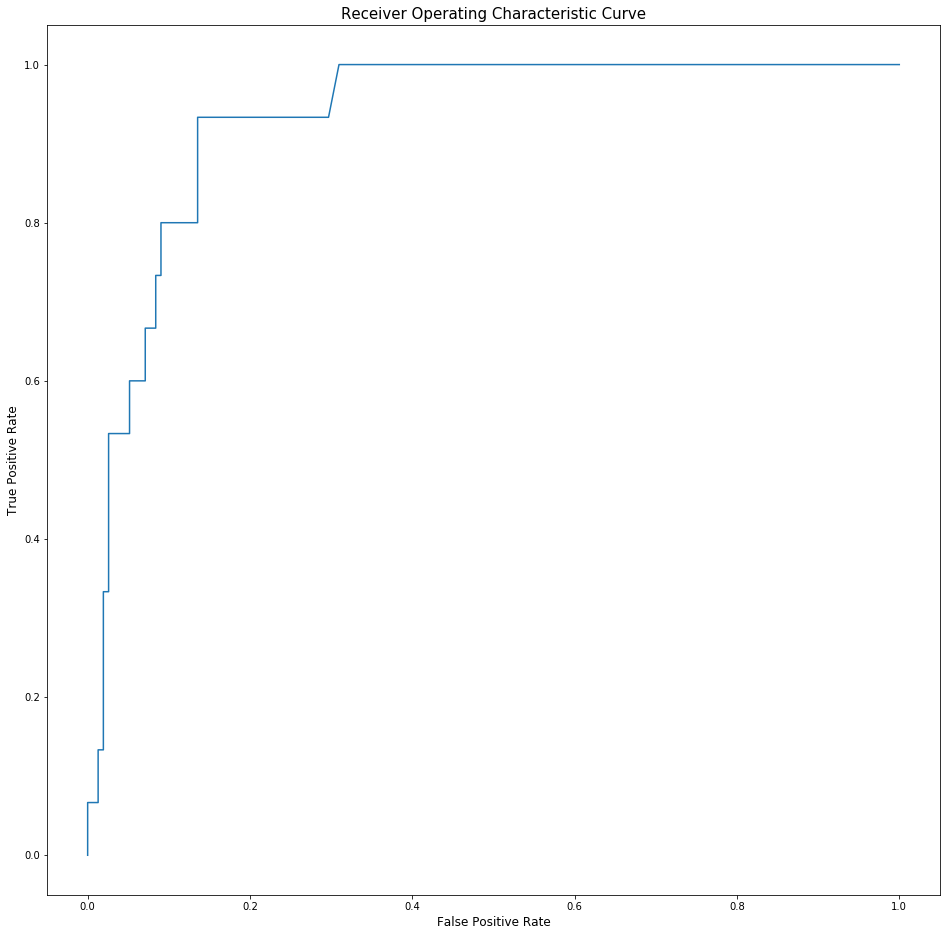

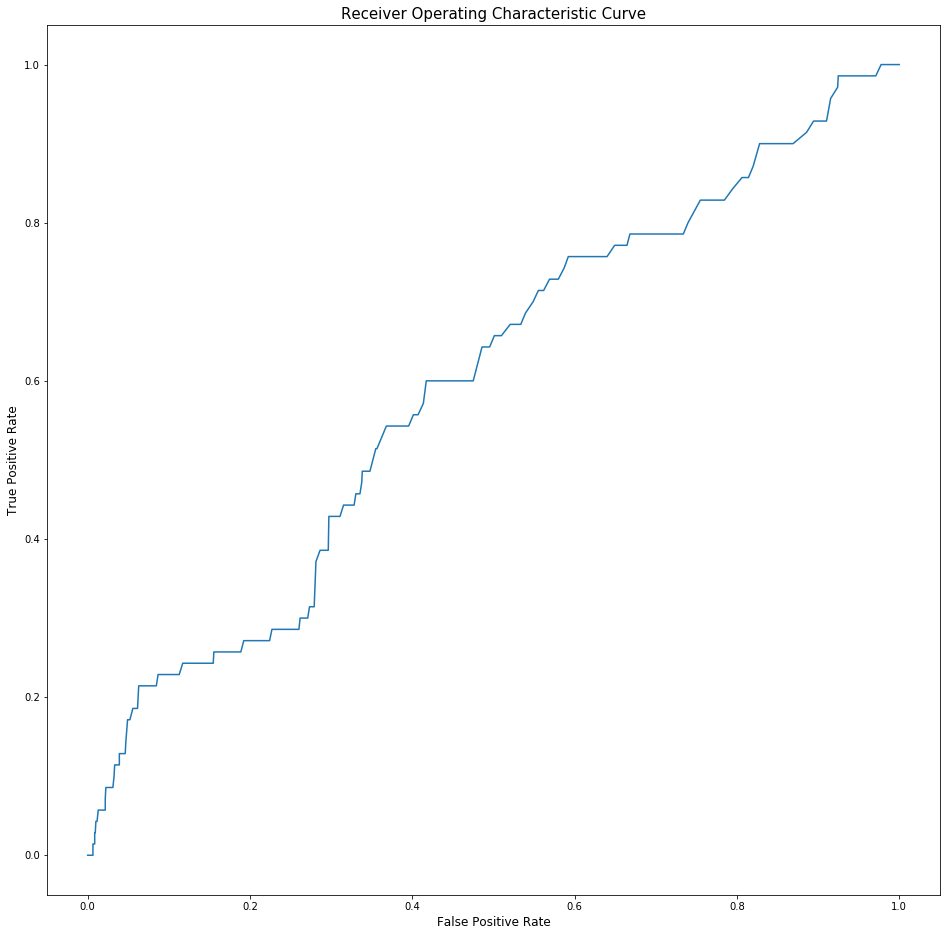

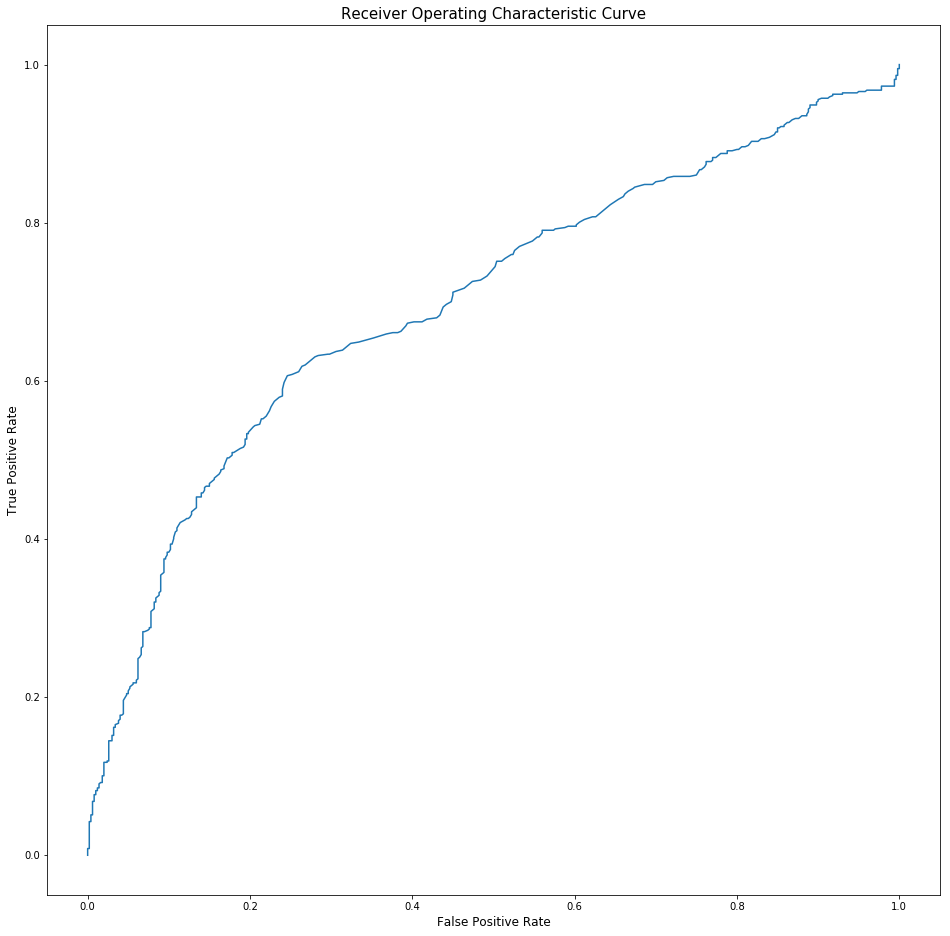

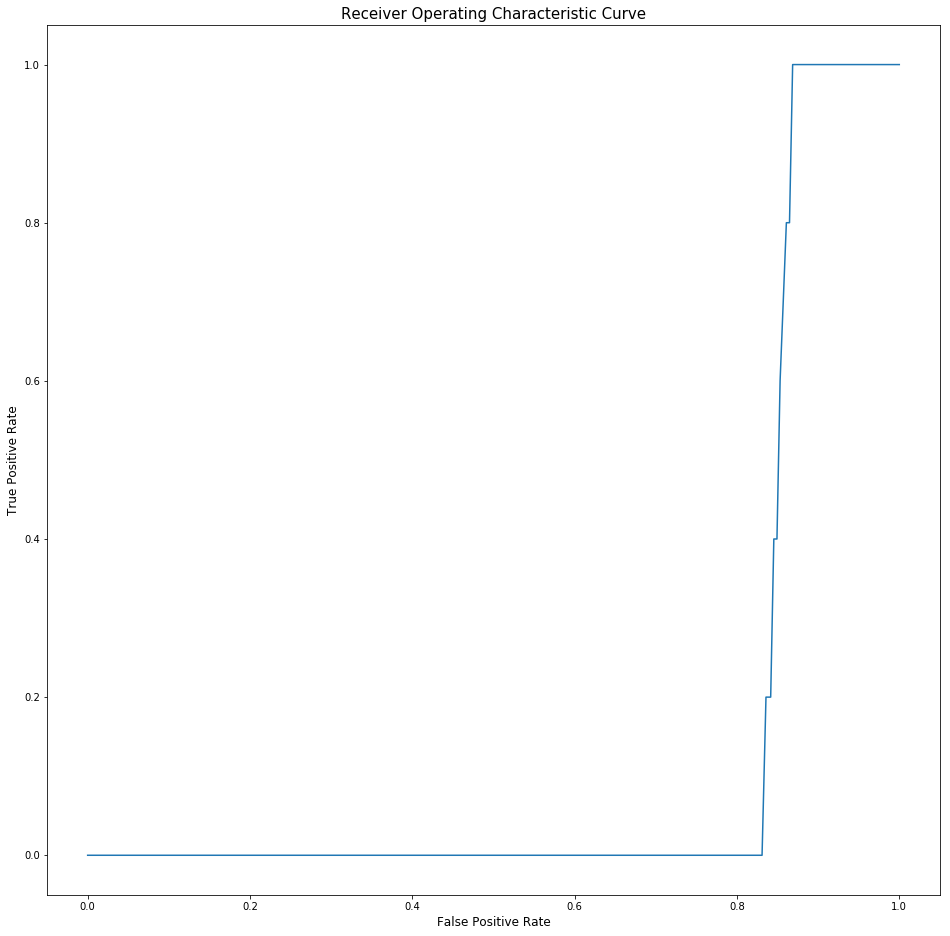

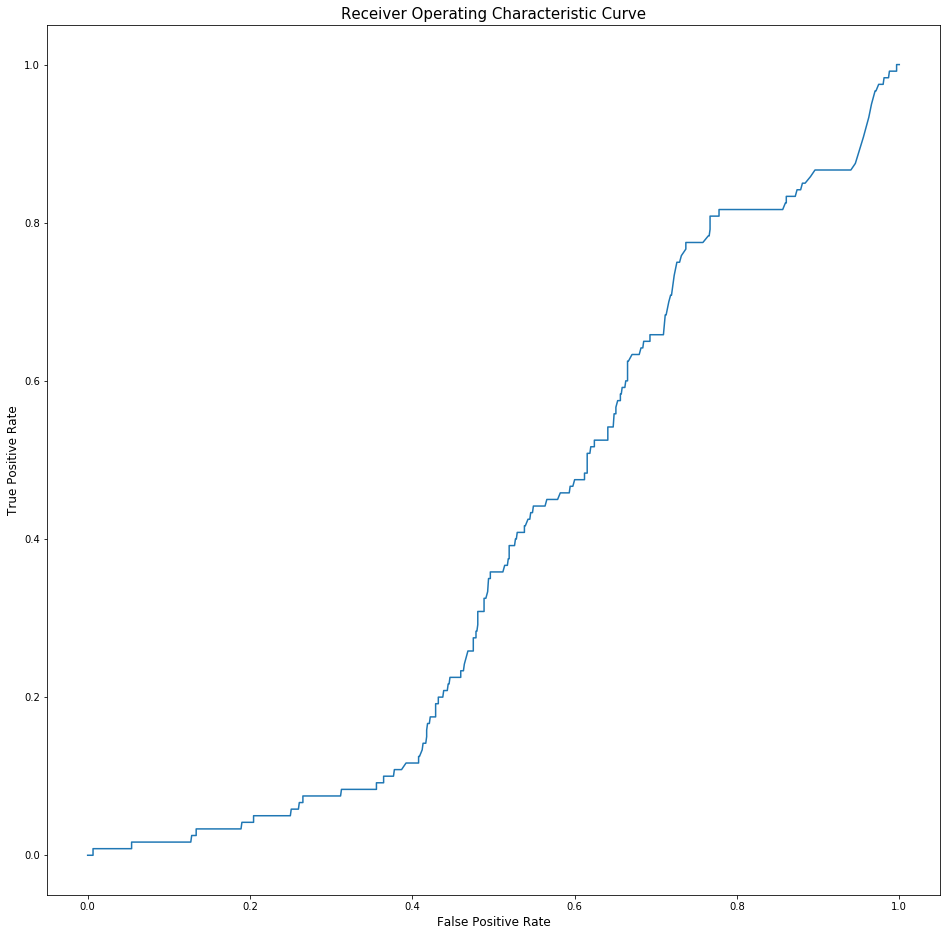

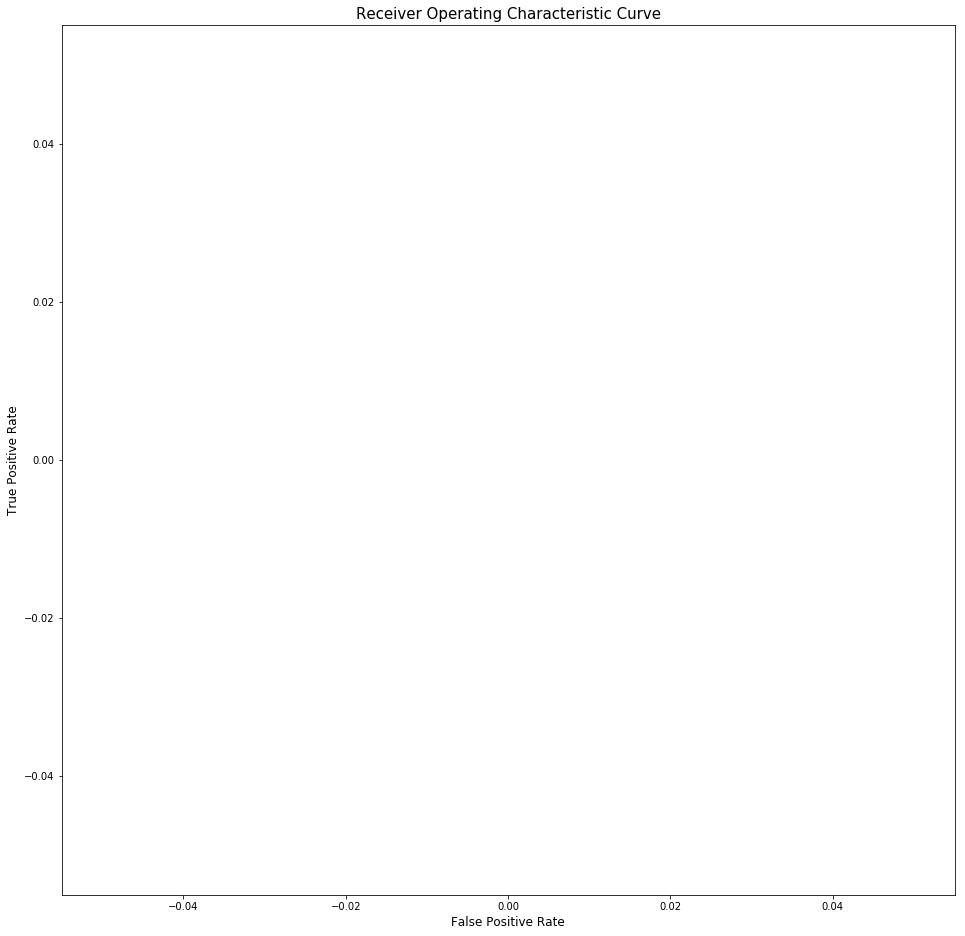

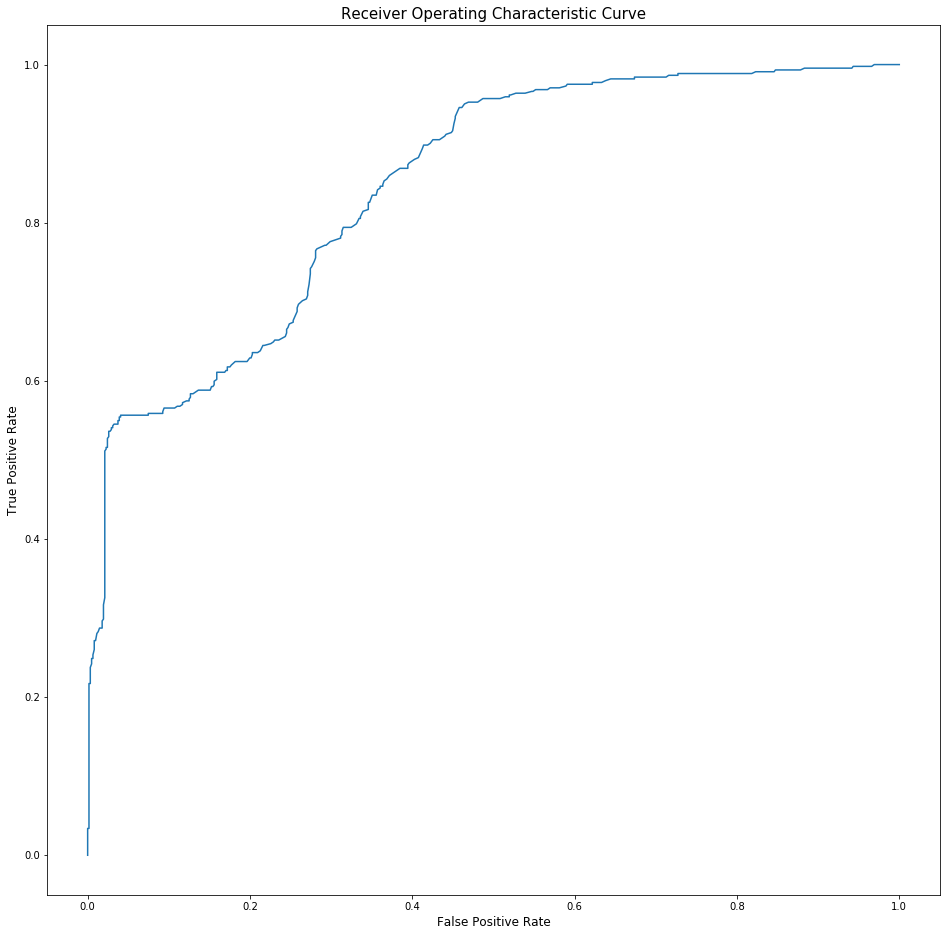

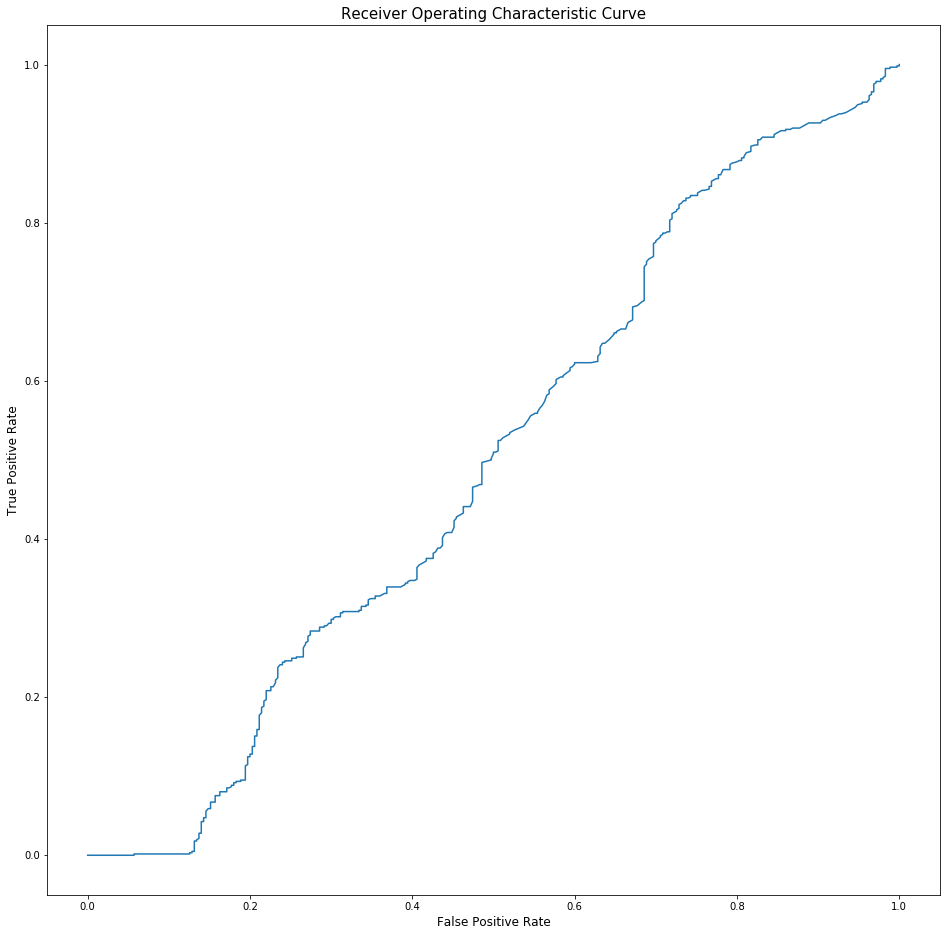

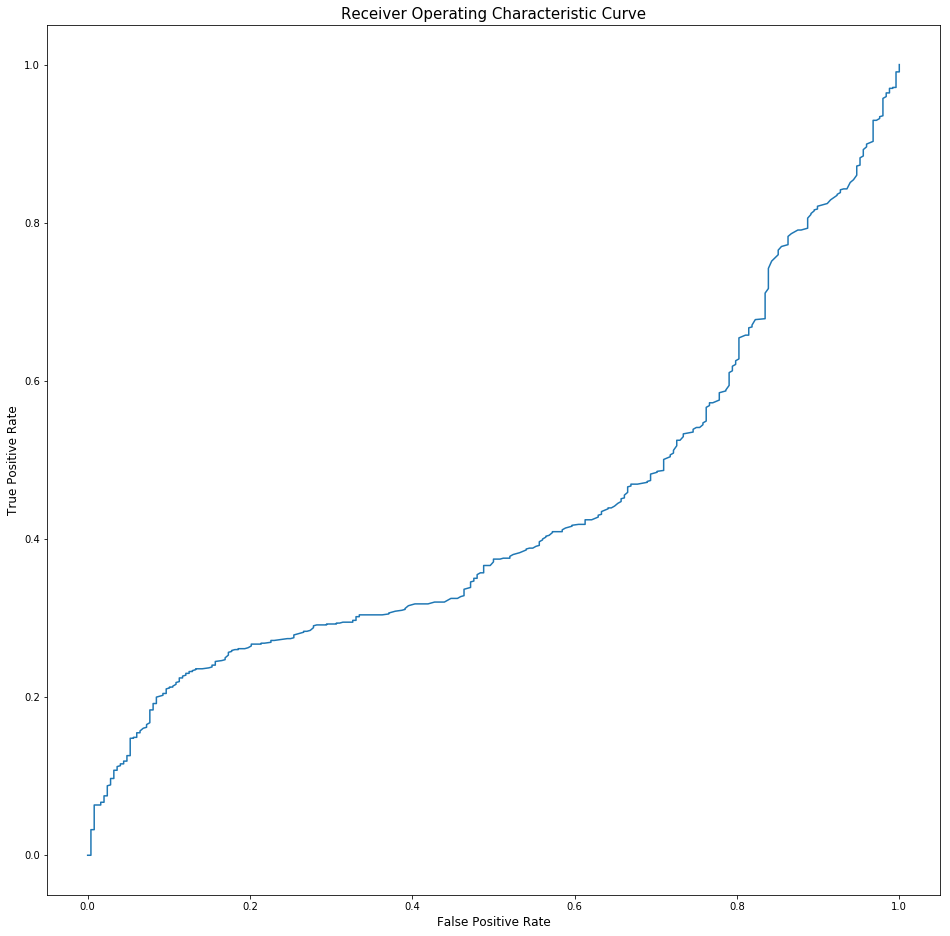

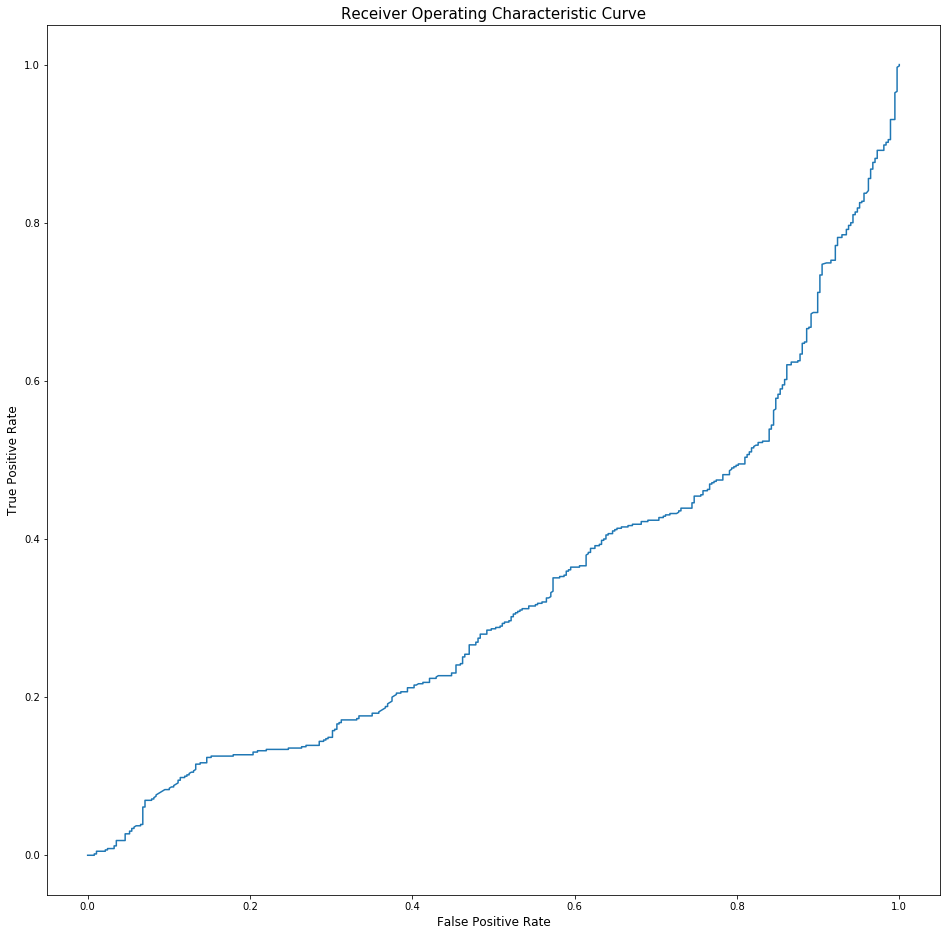

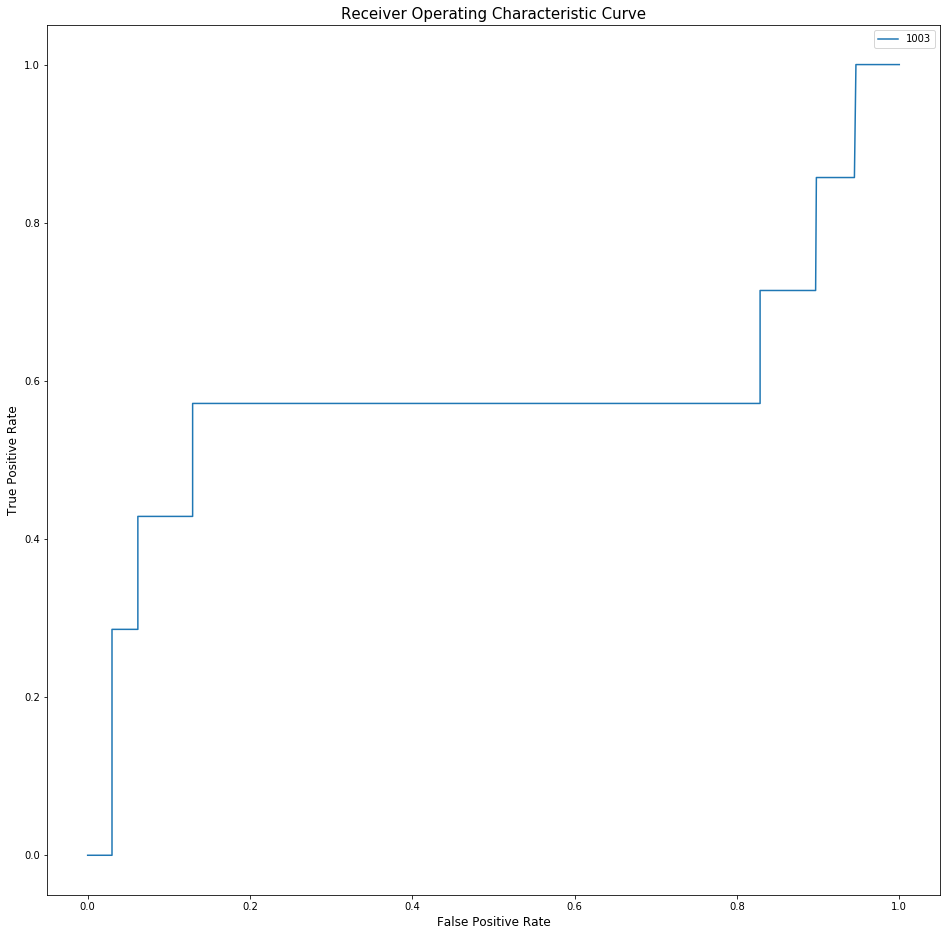

In [265]:
grouper = LeaveOneGroupOut()
valsubs = []
for trainInd, testInd in grouper.split(Data, Labels, groups = Subjects):
    trainData = Data[trainInd]
    trainLab = Labels[trainInd]
    testData = Data[testInd]
    testLab = Labels[testInd]
    subject = int(np.unique(Subjects[testInd]))
    valsubs = valsubs + [subject]
    
    print('Validation Subject: ' + str(subject))
    
    model = Sequential()
    model.add(LSTM(50, input_shape = (500, 3)))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'mae', optimizer = 'adam')
    try:
        history = model.fit(trainData, trainLab, epochs = 10, batch_size = int(len(trainInd) / 20), 
                            validation_data = (testData, testLab))
    except(KeyboardInterrupt):
        break
    PL = model.predict(testData)
    TL = testLab
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(TL, PL)
    plt.figure(figsize = (16, 16))
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate', fontsize = 12)
    plt.ylabel('True Positive Rate', fontsize = 12)
    plt.title('Receiver Operating Characteristic Curve', fontsize = 15)
    
#     plt.figure(figsize = (8, 8))
#     plt.plot(history.history['loss'], label = 'Train')
#     plt.plot(history.history['val_loss'], label = 'Test')
#     plt.title(str(subject))
#     plt.legend()
#     plt.ylim((0,1))
#     plt.show()
plt.legend(valsubs)
plt.show()

Text(0.5, 1.0, 'Receiver Operating Characteristic Curve')

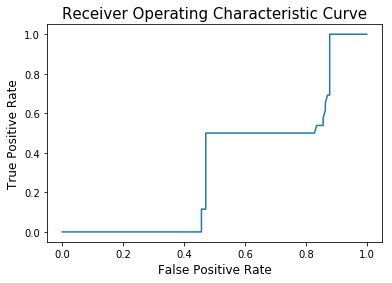

In [257]:
PL = model.predict(testData)
TL = testLab

fpr, tpr, thresholds = sklearn.metrics.roc_curve(TL, PL)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate', fontsize = 12)
plt.ylabel('True Positive Rate', fontsize = 12)
plt.title('Receiver Operating Characteristic Curve', fontsize = 15)